In [12]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import pickle as pk
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
import matplotlib.pyplot as plt
import statistics

In [2]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

In [3]:
#Here, we import the lists of hub exposures, central module exposures, peripheric exposures and no hub no module exposures
hub_exposures_list=[]
central_module_exposures_list=[]
peripheric_module_exposures_list=[]
no_central_no_module_exposures_list=[]
 
# Using readlines()
file1 = open('output/Hub_expusres.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    hub_exposures_list.append(line.strip("\n"))

# Using readlines()
file1 = open('output/Central_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    central_module_exposures_list.append(line.strip("\n"))
    
# Using readlines()
file1 = open('output/Peripheric_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    peripheric_module_exposures_list.append(line.strip("\n"))
    
# Using readlines()
file1 = open('output/No_central_no_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    no_central_no_module_exposures_list.append(line.strip("\n"))


In [4]:
len(set(hub_exposures_list+central_module_exposures_list+peripheric_module_exposures_list+no_central_no_module_exposures_list))

9852

In [3]:
len(set(hub_exposures_list+central_module_exposures_list))

5694

In [11]:
len(set(no_central_no_module_exposures_list))

3370

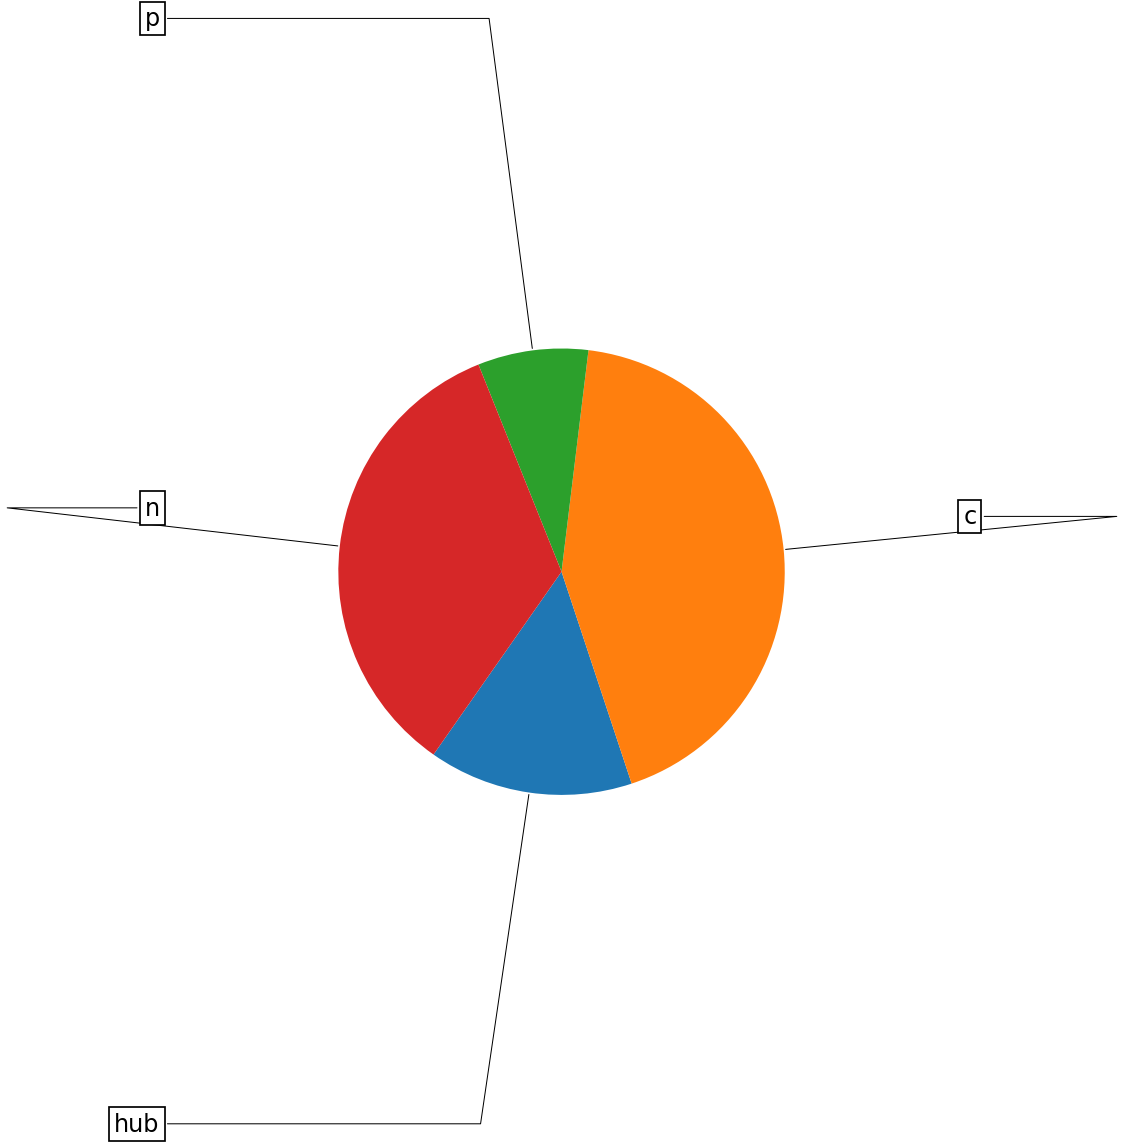

In [7]:
#Here, we show the proportion of the chemical classes in the entire CTD 
fig, ax = plt.subplots(figsize=(10, 20), subplot_kw=dict(aspect="equal"))
radius = 1

cmap = plt.cm.viridis



sizes=[len(hub_exposures_list),len(central_module_exposures_list),len(peripheric_module_exposures_list),len(no_central_no_module_exposures_list)]

wedges, texts = ax.pie(sizes, wedgeprops=dict(width=1), startangle=-125)

bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="k", lw=1.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

#for i, p in enumerate(wedges):
#    ang = (p.theta2 - p.theta1)/2. + p.theta1
#    y = np.sin(np.deg2rad(ang))
#    x = np.cos(np.deg2rad(ang))
#    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
#    kw["arrowprops"].update({"connectionstyle": connectionstyle})
#    ax.annotate(labels[i], xy=(x, y), xytext=(1.8*np.sign(x), 2.5*y),
                horizontalalignment=horizontalalignment,fontsize=24, **kw)
plt.savefig('output/Figures/Figure3D.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()

In [61]:
#Let's build also the vice-versa: the gene-chem dictionary
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])
        
#Here the cleaning process
gene_chem_cleaned={}
for k,v in gene_chem.items():
    if len(v)!=0:
        gene_chem_cleaned[k]=v
    else:
        pass

In [4]:
#Let's define a dictionary that will convert the chemical ID in chemical name
chem_id_cas_conversion = {}
for i,v in chem_homo.iterrows():
        chem_id_cas_conversion[v["ChemicalID"]] = v["CasRN"]

In [5]:
#Let's define a dictionary that will convert the chemical ID in chemical name
chem_id_name_conversion = {}
for i,v in chem_gene_df.iterrows():
        chem_id_name_conversion[v["ChemicalID"]] = v["# ChemicalName"]

In [8]:
#We are importing the toxicity data (Hazard) from NORMANN (Susdata0), this was updated at 18.01.2022
#(https://www.norman-network.com/nds/SLE/)
#We will use the hazard value 'HazScore_EcoChronic_KEMI', which ranges from 0 (no toxic) to 1 (super harmful)
#this score was calculated based on the hazard in ecosystem and as chronic exposures and it was reported by
#KEMI Market list, a list of the 30418 chemical compounds that are available in the EU market
#https://comptox.epa.gov/dashboard/chemical-lists/KEMIMARKET


susdat_toxicity_df=pd.read_excel('susdat_2022-01-18-104316.xlsx', index_col=0)  

In [19]:
susdat_toxicity_df[susdat_toxicity_df['Name']=='Endrin ']['HazScore_EcoChronic_KEMI'].values[0]

0.31

In [20]:
hub_exposures_haz_dict={}
for exp in hub_exposures_list:
    name_exp=chem_id_name_conversion[exp]
    cas_exp=chem_id_cas_conversion[exp]
    try:
        haz=susdat_toxicity_df[susdat_toxicity_df['Name']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
        hub_exposures_haz_dict[exp]=haz
    except:
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['Name_Dashboard']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
            hub_exposures_haz_dict[exp]=haz
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['Name_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                hub_exposures_haz_dict[exp]=haz
            except:
                try:
                    haz=susdat_toxicity_df[susdat_toxicity_df['Name_IUPAC']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                    hub_exposures_haz_dict[exp]=haz
                except:
                    try:
                        haz=susdat_toxicity_df[susdat_toxicity_df['Synonyms_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                        hub_exposures_haz_dict[exp]=haz
                    except:
                        try:
                            haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN']=="CAS_RN:"+cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                            hub_exposures_haz_dict[exp]=haz
                        except:
                            try:
                                haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN_Dashboard']==cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                                hub_exposures_haz_dict[exp]=haz
                            except: 
                                pass

In [45]:
for exp,haz in hub_exposures_haz_dict.items():
    if haz<=0.3:
        if len(chem_gene_dictio_cleaned_ppi[exp])<20:
            if len(set(chem_gene_dictio_cleaned_ppi['D004732'])&set(chem_gene_dictio_cleaned_ppi[exp]))<1:
                if len(set(chem_gene_dictio_cleaned_ppi['D014641'])&set(chem_gene_dictio_cleaned_ppi[exp]))<1:
                    G_ppi_sub = G_ppi.subgraph(chem_gene_dictio_cleaned_ppi[exp]) 
                    if G_ppi_sub.number_of_edges()>4:
                        for gene in chem_gene_dictio_cleaned_ppi[exp]:
                            if nx.degree(G_ppi,gene)>50:
                                print(exp,haz)


C027667 0.15
C027667 0.15
C027667 0.15
C036758 0.17
C036758 0.17
C036758 0.17
C055802 0.13
C055802 0.13
C030735 0.1
C030735 0.1
C030735 0.1
C030735 0.1
C030735 0.1
C030735 0.1
C030735 0.1
D000086 0.1
D000086 0.1
C031800 0.04
C031800 0.04
D019386 0.08
D019386 0.08
D019386 0.08
D019386 0.08
D019386 0.08
D000583 0.17
D000583 0.17
D000583 0.17
D000641 0.27
D000641 0.27
D000641 0.27
D000641 0.27
D000641 0.27
D000658 0.08
C018861 0.13
C018861 0.13
C019304 0.12
C019304 0.12
C019304 0.12
C019304 0.12
C019304 0.12
C007078 0.18
C007078 0.18
C007078 0.18
C007078 0.18
D004977 0.03
D004977 0.03
D005280 0.01
D005280 0.01
D005280 0.01
D005280 0.01
D000077604 0.04
D000077604 0.04
D000077604 0.04
D019807 0.04
D019807 0.04
D019807 0.04
D019807 0.04
D020366 0.27
D020105 0.1
D020105 0.1
D020105 0.1
D009583 0.04
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
D011441 0.16
D011441 0.16
D011441 0.16
D011441 0.16
D011441 0.16
D0

In [46]:
# open file in write mode
with open('output/Methylmethacrylate.txt', 'w') as fp:
    for item in chem_gene_dictio_cleaned_ppi['D020366']:
        # write each item on a new line
        fp.write("%s\n" % item)


In [34]:
# open file in write mode
with open('output/Benthiocarb.txt', 'w') as fp:
    for item in chem_gene_dictio_cleaned_ppi['C037925']:
        # write each item on a new line
        fp.write("%s\n" % item)


In [28]:

peripheric_module_haz_dict={}
for exp in peripheric_module_exposures_list:
    name_exp=chem_id_name_conversion[exp]
    cas_exp=chem_id_cas_conversion[exp]
    try:
        haz=susdat_toxicity_df[susdat_toxicity_df['Name']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
        peripheric_module_haz_dict[exp] = haz
    except:
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['Name_Dashboard']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
            peripheric_module_haz_dict[exp] = haz
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['Name_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                peripheric_module_haz_dict[exp] = haz
            except:
                try:
                    haz=susdat_toxicity_df[susdat_toxicity_df['Name_IUPAC']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                    peripheric_module_haz_dict[exp] = haz
                except:
                    try:
                        haz=susdat_toxicity_df[susdat_toxicity_df['Synonyms_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                        peripheric_module_haz_dict[exp] = haz
                    except:
                        try:
                            haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN']=="CAS_RN:"+cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                            peripheric_module_haz_dict[exp] = haz
                        except:
                            try:
                                haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN_Dashboard']==cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                                peripheric_module_haz_dict[exp] = haz
                            except: 
                                pass

In [42]:
for exp,haz in peripheric_module_haz_dict.items():
    if haz<=0.2:
        if len(chem_gene_dictio_cleaned_ppi[exp])<20 and len(chem_gene_dictio_cleaned_ppi[exp])>3:
            if len(set(chem_gene_dictio_cleaned_ppi['D004732'])&set(chem_gene_dictio_cleaned_ppi[exp]))<1:
                G_ppi_sub = G_ppi.subgraph(chem_gene_dictio_cleaned_ppi[exp]) 
                if G_ppi_sub.number_of_edges()>10:
                    print(exp,haz)

D015104 0.04
C035253 0.01
D001640 0.1
C075375 0.01
D006923 0.02
D008717 0.01
D010852 0.02
D012603 0.01
D014641 0.01


In [43]:
# open file in write mode
with open('output/Vanillic_acid.txt', 'w') as fp:
    for item in chem_gene_dictio_cleaned_ppi['D014641']:
        # write each item on a new line
        fp.write("%s\n" % item)

In [33]:
# open file in write mode
with open('output/Diflubenzuron.txt', 'w') as fp:
    for item in chem_gene_dictio_cleaned_ppi['D004132']:
        # write each item on a new line
        fp.write("%s\n" % item)


In [9]:
#Here we match our exposures IDs with the exposures names and CAS numbers provided by NORMAN
hub_haz_list=[]
for exp in hub_exposures_list:
    name_exp=chem_id_name_conversion[exp]
    cas_exp=chem_id_cas_conversion[exp]
    try:
        haz=susdat_toxicity_df[susdat_toxicity_df['Name']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
        hub_haz_list.append(haz)
    except:
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['Name_Dashboard']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
            hub_haz_list.append(haz)
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['Name_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                hub_haz_list.append(haz)
            except:
                try:
                    haz=susdat_toxicity_df[susdat_toxicity_df['Name_IUPAC']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                    hub_haz_list.append(haz)
                except:
                    try:
                        haz=susdat_toxicity_df[susdat_toxicity_df['Synonyms_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                        hub_haz_list.append(haz)
                    except:
                        try:
                            haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN']=="CAS_RN:"+cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                            hub_haz_list.append(haz)
                        except:
                            try:
                                haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN_Dashboard']==cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                                hub_haz_list.append(haz)
                            except: 
                                pass
        
        
hub_haz_list_cleaned = [x for x in hub_haz_list if str(x) != 'nan']



central_module_haz_list=[]
for exp in central_module_exposures_list:
    name_exp=chem_id_name_conversion[exp]
    cas_exp=chem_id_cas_conversion[exp]
    try:
        haz=susdat_toxicity_df[susdat_toxicity_df['Name']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
        central_module_haz_list.append(haz)
    except:
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['Name_Dashboard']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
            central_module_haz_list.append(haz)
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['Name_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                central_module_haz_list.append(haz)
            except:
                try:
                    haz=susdat_toxicity_df[susdat_toxicity_df['Name_IUPAC']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                    central_module_haz_list.append(haz)
                except:
                    try:
                        haz=susdat_toxicity_df[susdat_toxicity_df['Synonyms_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                        central_module_haz_list.append(haz)
                    except:
                        try:
                            haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN']=="CAS_RN:"+cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                            central_module_haz_list.append(haz)
                        except:
                            try:
                                haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN_Dashboard']==cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                                central_module_haz_list.append(haz)
                            except: 
                                pass
        
        
central_module_haz_list_cleaned = [x for x in central_module_haz_list if str(x) != 'nan']



peripheric_module_haz_list=[]
for exp in peripheric_module_exposures_list:
    name_exp=chem_id_name_conversion[exp]
    cas_exp=chem_id_cas_conversion[exp]
    try:
        haz=susdat_toxicity_df[susdat_toxicity_df['Name']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
        peripheric_module_haz_list.append(haz)
    except:
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['Name_Dashboard']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
            peripheric_module_haz_list.append(haz)
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['Name_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                peripheric_module_haz_list.append(haz)
            except:
                try:
                    haz=susdat_toxicity_df[susdat_toxicity_df['Name_IUPAC']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                    peripheric_module_haz_list.append(haz)
                except:
                    try:
                        haz=susdat_toxicity_df[susdat_toxicity_df['Synonyms_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                        peripheric_module_haz_list.append(haz)
                    except:
                        try:
                            haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN']=="CAS_RN:"+cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                            peripheric_module_haz_list.append(haz)
                        except:
                            try:
                                haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN_Dashboard']==cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                                peripheric_module_haz_list.append(haz)
                            except: 
                                pass
        
        
peripheric_module_haz_list_cleaned = [x for x in peripheric_module_haz_list if str(x) != 'nan']



nocentral_nomodule_haz_list=[]
for exp in no_central_no_module_exposures_list:
    name_exp=chem_id_name_conversion[exp]
    cas_exp=chem_id_cas_conversion[exp]
    try:
        haz=susdat_toxicity_df[susdat_toxicity_df['Name']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
        nocentral_nomodule_haz_list.append(haz)
    except:
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['Name_Dashboard']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
            nocentral_nomodule_haz_list.append(haz)
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['Name_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                nocentral_nomodule_haz_list.append(haz)
            except:
                try:
                    haz=susdat_toxicity_df[susdat_toxicity_df['Name_IUPAC']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                    nocentral_nomodule_haz_list.append(haz)
                except:
                    try:
                        haz=susdat_toxicity_df[susdat_toxicity_df['Synonyms_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                        nocentral_nomodule_haz_list.append(haz)
                    except:
                        try:
                            haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN']=="CAS_RN:"+cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                            nocentral_nomodule_haz_list.append(haz)
                        except:
                            try:
                                haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN_Dashboard']==cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                                nocentral_nomodule_haz_list.append(haz)
                            except: 
                                pass
        
        
nocentral_nomodule_haz_list_cleaned = [x for x in nocentral_nomodule_haz_list if str(x) != 'nan']



            
print("This is the ratio of found exposures with hazard annotation for hub exposures: %s" %(len(hub_haz_list_cleaned)/len(hub_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for central module exposures: %s" %(len(central_module_haz_list_cleaned)/len(central_module_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for peripheric module exposures: %s" %(len(peripheric_module_haz_list_cleaned)/len(peripheric_module_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for no module no hub exposures: %s" %(len(nocentral_nomodule_haz_list_cleaned)/len(no_central_no_module_exposures_list)))


This is the ratio of found exposures with hazard annotation for hub exposures: 0.27553118574366003
This is the ratio of found exposures with hazard annotation for central module exposures: 0.31711924439197164
This is the ratio of found exposures with hazard annotation for peripheric module exposures: 0.2893401015228426
This is the ratio of found exposures with hazard annotation for no module no hub exposures: 0.2626112759643917


In [13]:
np.max(central_module_haz_list_cleaned)

0.83

In [27]:
np.max(hub_haz_list_cleaned)

0.68

In [28]:
np.max(nocentral_nomodule_haz_list_cleaned)

0.57

In [11]:
np.max(peripheric_module_haz_list_cleaned)

0.56

In [21]:
np.median(central_module_haz_list_cleaned)

0.13

In [23]:
np.median(hub_haz_list_cleaned)

0.11

In [24]:
np.median(nocentral_nomodule_haz_list_cleaned)

0.1

In [25]:
np.median(peripheric_module_haz_list_cleaned)

0.09

In [90]:
import pandas as pd
column_names = ["Hazard", "Group"]

haz_count_df = pd.DataFrame(columns = column_names)

for i in hub_haz_list_cleaned:
    new_row={"Hazard":i,"Group":"Hub"}
    haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
for i in central_module_haz_list_cleaned:
    new_row={"Hazard":i,"Group":"Central Module"}
    haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
for i in peripheric_module_haz_list_cleaned:
    new_row={"Hazard":i,"Group":"Peripheral Module"}
    haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
    
for i in nocentral_nomodule_haz_list_cleaned:
    new_row={"Hazard":i,"Group":"Scattered"}
    haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_89192/2921862100.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,0,0.2,0.4,0.6,0.8,1], size = 36)


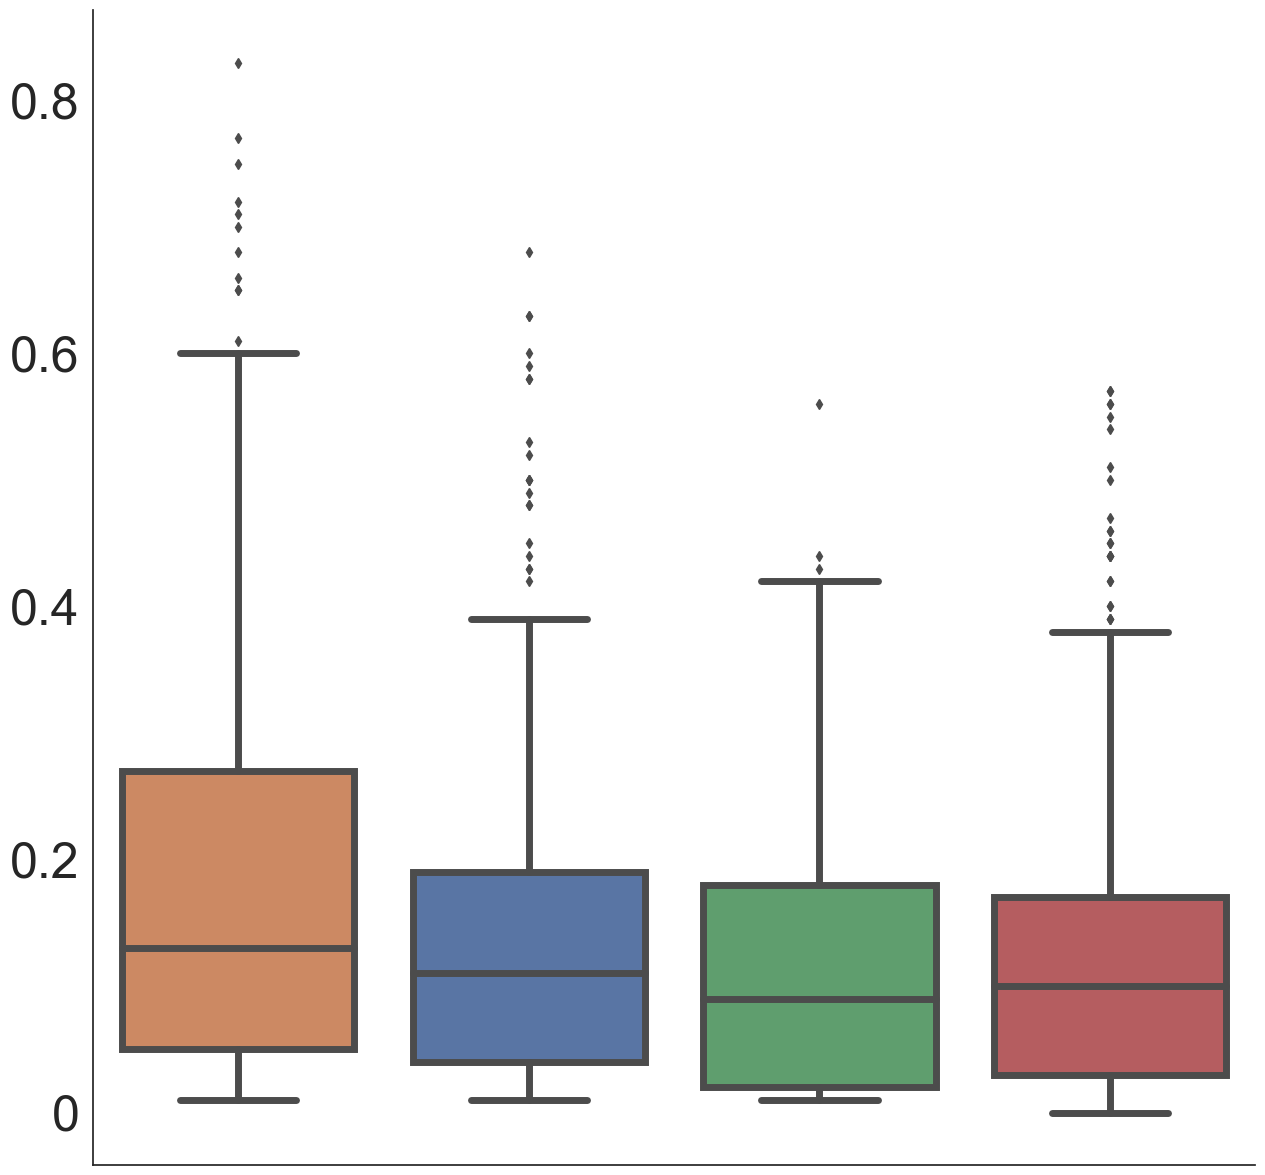

In [97]:

from itertools import combinations
pairs = list(combinations(list(set(haz_count_df['Group'])), r=2))


#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

list_palette=list(sns.color_palette())

my_pal = {"Central Module":list_palette[1] , "Hub": list_palette[0], "Peripheral Module":list_palette[2], "Scattered":list_palette[3]}


g=sns.boxplot(data=haz_count_df,x="Group", y="Hazard",order=["Central Module","Hub","Peripheral Module","Scattered"],palette=my_pal,linewidth=5)
plt.xlabel('',fontsize=22)
plt.ylabel('', fontsize=22)
plt.xticks([], fontsize=22)
ax.grid(False)
ax.set_yticklabels([0,0,0.2,0.4,0.6,0.8,1], size = 36)
plt.savefig('output/Figures/Figure3Gv4.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#g.set_yscale("log")
plt.show()


<ipython-input-41-7785bf26f6cb>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,0,0.2,0.4,0.6,0.8], size = 36)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Nomodnohub vs. Central Module: Mann-Whitney-Wilcoxon test two-sided, P_val:1.980e-16 U_stat=4.723e+05
Central Module vs. Hub: Mann-Whitney-Wilcoxon test two-sided, P_val:5.343e-05 U_stat=3.057e+05
Hub vs. Peripheric Module: Mann-Whitney-Wilcoxon test two-sided, P_val:3.230e-02 U_stat=5.052e+04
Nomodnohub vs. Hub: Mann-Whitney-Wilcoxon test two-sided, P_val:3.790e-02 U_stat=1.651e+05
Central Module vs. Peripheric Module: Mann-Whitney-Wilcoxon test two-sided, P_val:2.655e-08 U_stat=1.883e+05
Nomodnohub vs. Peripheric Module: Mann-Whitney-Wilcoxon test two-sided, P_val:4.653e-01 U_stat=1.040e+05


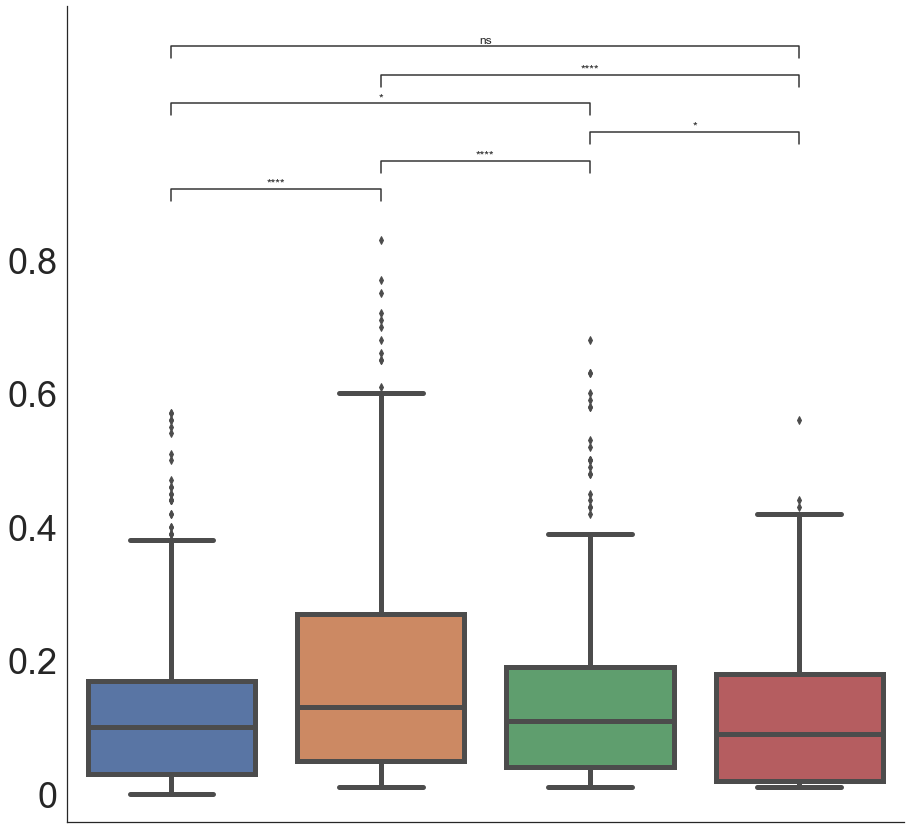

In [41]:
#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=haz_count_df,x="Group", y="Hazard",order=list(set(haz_count_df['Group'])),linewidth=5)
plt.xlabel('',fontsize=36)
plt.ylabel('', fontsize=36)
plt.xticks([], fontsize=36)
ax.grid(False)
ax.set_yticklabels([0,0,0.2,0.4,0.6,0.8], size = 36)

annotator = Annotator(ax, pairs, data=haz_count_df,x="Group", y="Hazard",order=list(set(haz_count_df['Group'])), verbose=36)
annotator.configure(test="Mann-Whitney")
annotator.apply_and_annotate()

#plt.savefig('output/Figures/Figure3E.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#g.set_yscale("log")
plt.show()



<ipython-input-42-8a3962446381>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,0,0.2,0.4,0.6,0.8,1], size = 36)


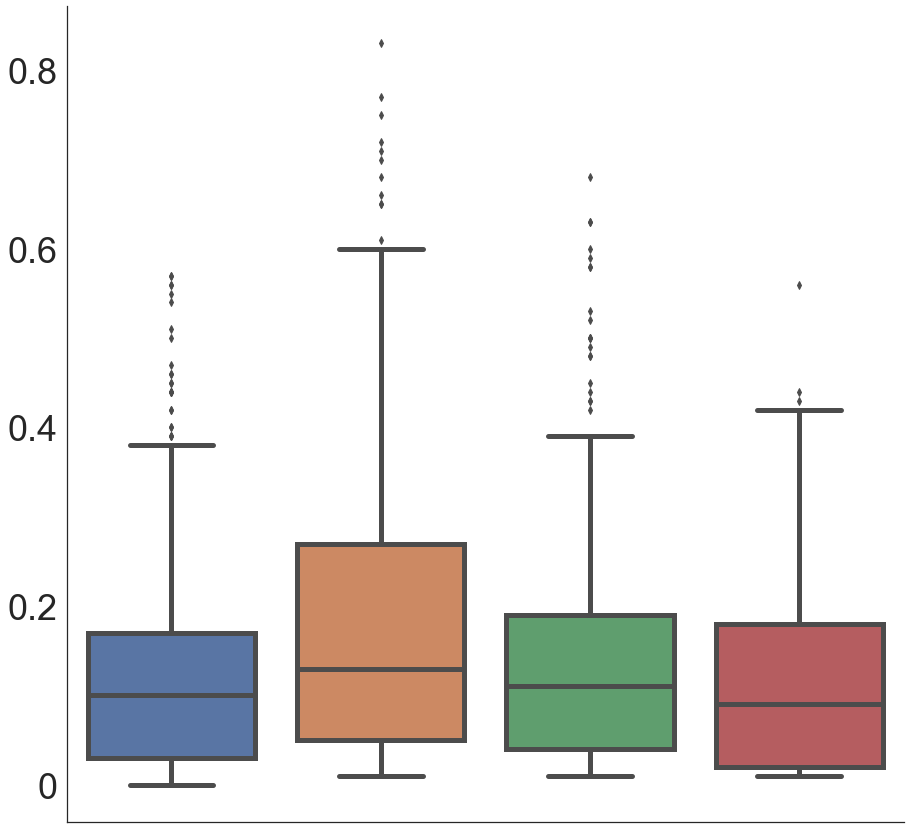

In [42]:
#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=haz_count_df,x="Group", y="Hazard",order=list(set(haz_count_df['Group'])),linewidth=5)
plt.xlabel('',fontsize=22)
plt.ylabel('', fontsize=22)
plt.xticks([], fontsize=22)
ax.grid(False)
ax.set_yticklabels([0,0,0.2,0.4,0.6,0.8,1], size = 36)
plt.savefig('output/Figures/Figure3Ev2.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#g.set_yscale("log")
plt.show()



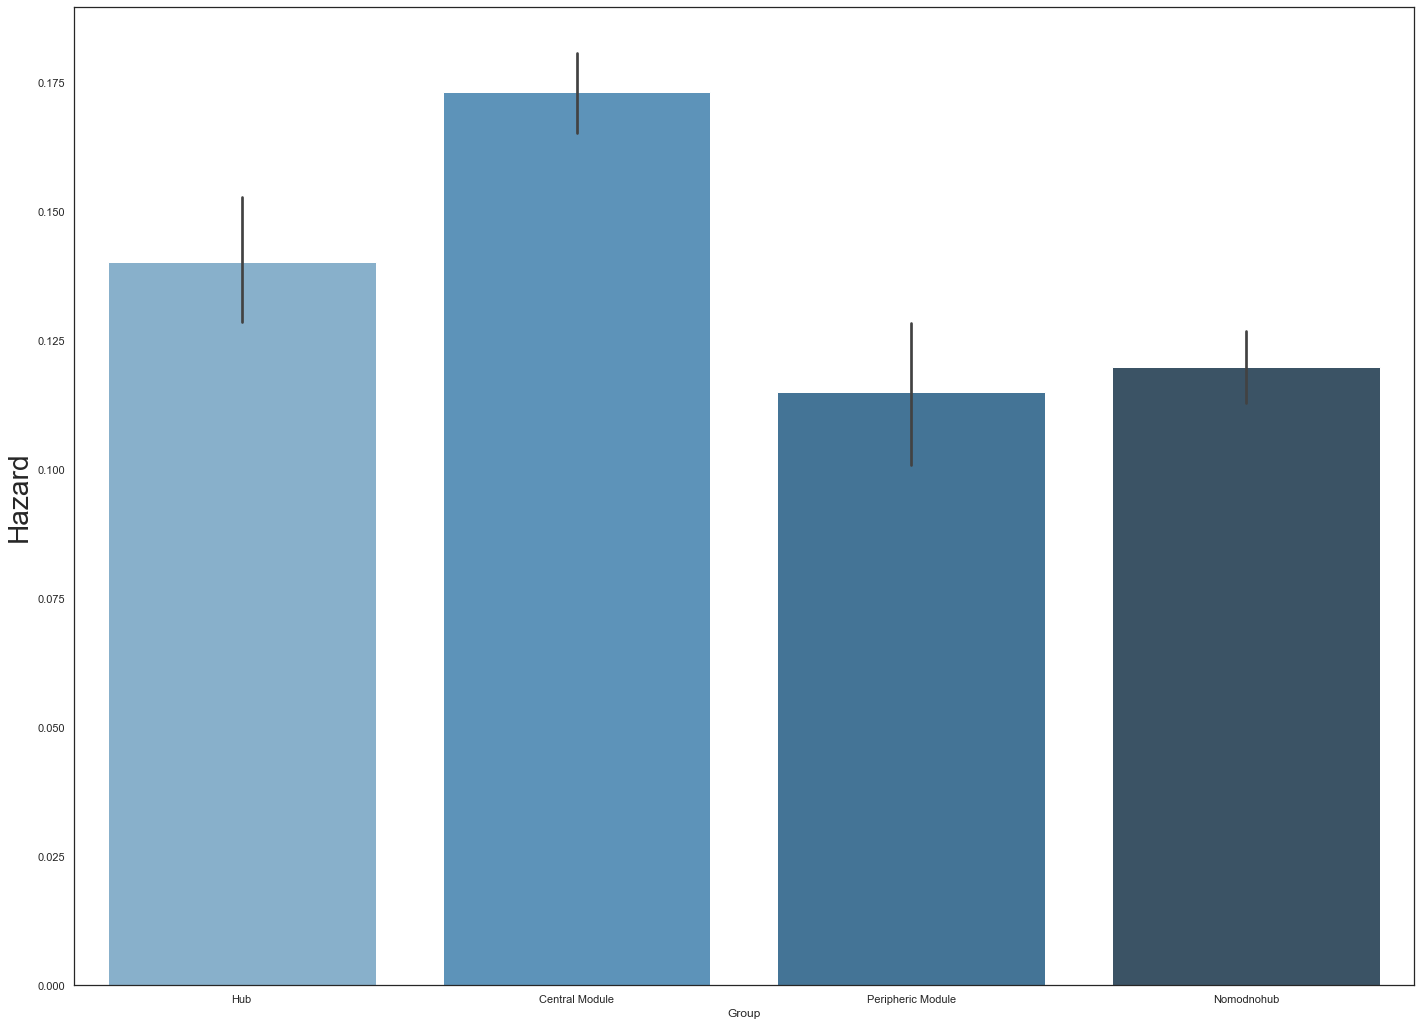

In [15]:
#Let's visualize as barplots
fig, ax = plt.subplots(figsize=(24, 18))
ax = sns.barplot(x="Group", y="Hazard", data=haz_count_df,
                 palette="Blues_d",estimator=np.mean)
#ax.set_yscale("log")
#ax.set_title("Association between proximity and literature",fontsize=28)
ax.set_ylabel("Hazard",fontsize=28)
#ax.set_xlabel("Group",fontsize=28)
plt.show()

In [69]:
#Let's make some statistics
import scipy
print(scipy.stats.mannwhitneyu(hub_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(central_module_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(peripheric_module_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(central_module_haz_list_cleaned, peripheric_module_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(hub_haz_list_cleaned, central_module_haz_list_cleaned, use_continuity=True, alternative='two-sided'))






MannwhitneyuResult(statistic=190677.0, pvalue=0.03789948355458428)
MannwhitneyuResult(statistic=716214.5, pvalue=1.979515312547919e-16)
MannwhitneyuResult(statistic=97740.0, pvalue=0.4653039736295932)
MannwhitneyuResult(statistic=188275.5, pvalue=2.6546508236777083e-08)
MannwhitneyuResult(statistic=234191.0, pvalue=5.343017971833708e-05)


/Users/lsd/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lsd/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 61.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lsd/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 19.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/lsd/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 57.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


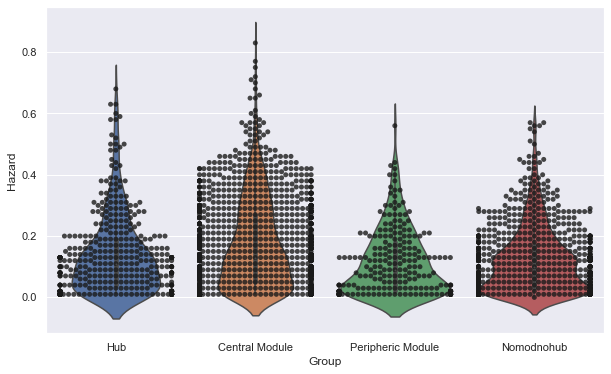

In [106]:
plt.figure(figsize=(10,6))


sns.violinplot(x="Group", y="Hazard", data=haz_count_df)
sns.swarmplot(x="Group", y="Hazard", data=haz_count_df, color="k", alpha=0.8)


plt.show()


In [21]:
#Here, we want to test the the main driver of hazard is the centrality in the PPI, for this reason we are going to
#associate for each exposure a median degree value of the degree of the perturbed genes for that exposure.



#Here, we import the merged PPI
ppi = pd.read_csv("input/PPI/autocore_symbol_lcc.csv",delimiter= ',',
           skipinitialspace=True)

G_ppi = nx.from_pandas_edgelist(ppi, 'symbol1', 'symbol2')

G_ppi_lcc = G_ppi.subgraph(max(nx.connected_components(G_ppi), key=len))  # extract lcc graph
print(G_ppi_lcc.number_of_nodes())
print(G_ppi_lcc.number_of_edges())

#Here, we create a dictionary out of the dataframe that has as a key the exposures and as 
#values the set of the genes that they perturb
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])
        
        
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)           
    else:
        pass
    
chem_gene_dictio_cleaned_ppi={}
for k,v in chem_gene_cleaned.items():
    new_list=[]
    for gene in v:
        if gene in G_ppi_lcc.nodes():
            new_list.append(gene)
        else:
            pass
    if len(new_list)>0:
        chem_gene_dictio_cleaned_ppi[k]=new_list
    else:
        pass



18815
482935


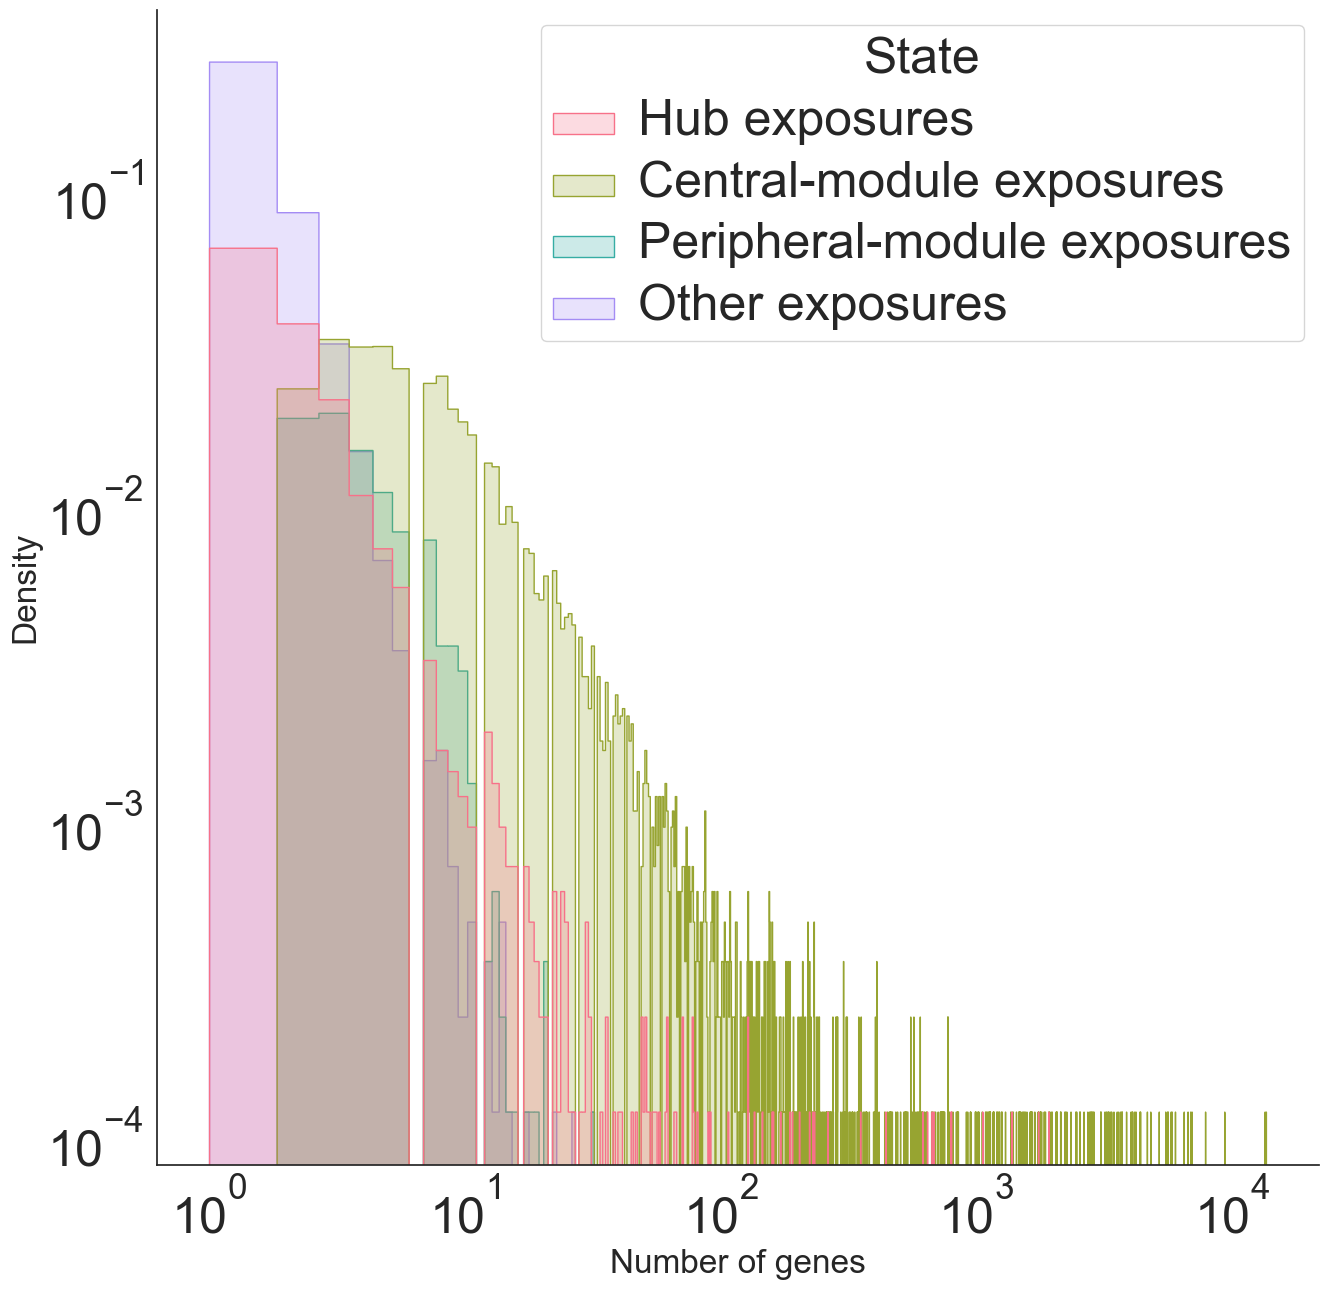

In [74]:
import seaborn as sns

state=[]
hub_exposures_number_of_genes=[]
central_module_exposures_number_of_genes=[]
peripheric_module_exposures_number_of_genes=[]
no_central_no_module_exposures_number_of_genes=[]

for exp in hub_exposures_list:
    hub_exposures_number_of_genes.append(len(chem_gene_dictio_cleaned_ppi[exp]))
    state.append("Hub exposures")
for exp in central_module_exposures_list:
    central_module_exposures_number_of_genes.append(len(chem_gene_dictio_cleaned_ppi[exp]))
    state.append("Central-module exposures")
for exp in peripheric_module_exposures_list:
    peripheric_module_exposures_number_of_genes.append(len(chem_gene_dictio_cleaned_ppi[exp]))
    state.append("Peripheral-module exposures")
for exp in no_central_no_module_exposures_list:
    no_central_no_module_exposures_number_of_genes.append(len(chem_gene_dictio_cleaned_ppi[exp]))
    state.append("Other exposures")


expstatnumperturb_df=pd.DataFrame()

expstatnumperturb_df['N_genes']=hub_exposures_number_of_genes+central_module_exposures_number_of_genes+peripheric_module_exposures_number_of_genes+no_central_no_module_exposures_number_of_genes

expstatnumperturb_df['State']=state


fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.xlabel('Resnik',fontsize=18)
#plt.ylabel('Frequency', fontsize=18)

#plt.title('Resnik distribution of total genes in each hierarchical level of clustering of EEN', fontsize=28)
g=sns.histplot(
    expstatnumperturb_df, x="N_genes", hue="State", element="step",palette='husl',
    stat="density"
)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

g.set(xlabel="Number of genes")
g.set(ylabel="Density")
g.set(xscale="log")
g.set(yscale="log")
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
plt.savefig('output/Figures/Fig3D+_v01.pdf',format='pdf',dpi=300, bbox_inches = "tight", transparent=True)


In [20]:


def median_degree(genelist):
    median_degree=[]
    for gene in genelist:
        median_degree.append(G_ppi_lcc.degree(gene))
    median_degree=statistics.median(median_degree)
    return median_degree

chem_med_degree={}
for chem, genelist in chem_gene_dictio_cleaned_ppi.items():
    chem_med_degree[chem]=median_degree(genelist)

True
(-0.030420541483660374, 0.10395921213640225)
SpearmanrResult(correlation=0.014039610721152512, pvalue=0.45309213414670646)


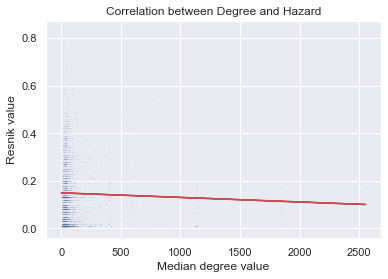

In [116]:
#Then, we will make a correlation plot to visualize whether there is a positive correlation between degree and hazard
import scipy

med_deg_list=[]
haz_list=[]
for chem,med_deg in chem_med_degree.items():
    name_exp=chem_id_name_conversion[chem]
    cas_exp=chem_id_cas_conversion[chem]
    try:
        haz=susdat_toxicity_df[susdat_toxicity_df['Name']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
        if str(haz)!='nan':
            haz_list.append(haz)
            med_deg_list.append(med_deg)
    except:
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['Name_Dashboard']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
            if str(haz)!='nan':
                haz_list.append(haz)
                med_deg_list.append(med_deg)
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['Name_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                if str(haz)!='nan':
                    haz_list.append(haz)
                    med_deg_list.append(med_deg)
            except:
                try:
                    haz=susdat_toxicity_df[susdat_toxicity_df['Name_IUPAC']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                    if str(haz)!='nan':
                        haz_list.append(haz)
                        med_deg_list.append(med_deg)
                except:
                    try:
                        haz=susdat_toxicity_df[susdat_toxicity_df['Synonyms_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                        if str(haz)!='nan':
                            haz_list.append(haz)
                            med_deg_list.append(med_deg)
                    except:
                        try:
                            haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN']=="CAS_RN:"+cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                            if str(haz)!='nan':
                                haz_list.append(haz)
                                med_deg_list.append(med_deg)
                        except:
                            try:
                                haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN_Dashboard']==cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                                if str(haz)!='nan':
                                    haz_list.append(haz)
                                    med_deg_list.append(med_deg)
                            except: 
                                pass
        
print(len(med_deg_list)==len(haz_list))


print(scipy.stats.pearsonr(med_deg_list,haz_list))  # Pearson's r
print(scipy.stats.spearmanr(med_deg_list,haz_list)) # Spearman's rho
slope, intercept, r, p, stderr = scipy.stats.linregress(med_deg_list,haz_list)
fig, ax = plt.subplots()
ax.scatter(med_deg_list,haz_list, s= 0.001)
y=[]
for i in med_deg_list:
    g=(intercept + slope * i)
    y.append(g)


ax.plot(med_deg_list, y,color='r')
ax.set_xlabel('Median degree value')
ax.set_ylabel('Hazard')

plt.title('Correlation between Degree and Hazard')
#ax.legend(facecolor='white')
plt.show()


In [21]:
#We do not observe any positive correlation between the median degree value and the Hazard, let's try considering
#the max degree

def max_degree(genelist):
    degree_list=[]
    for gene in genelist:
        degree_list.append(G_ppi_lcc.degree(gene))
    max_degree=max(degree_list)
    return max_degree

chem_max_degree={}
for chem, genelist in chem_gene_dictio_cleaned_ppi.items():
    chem_max_degree[chem]=max_degree(genelist)

True
PearsonRResult(statistic=0.2335264514189051, pvalue=1.0594073481391516e-36)
SignificanceResult(statistic=0.19862843146806006, pvalue=8.105558321593844e-27)


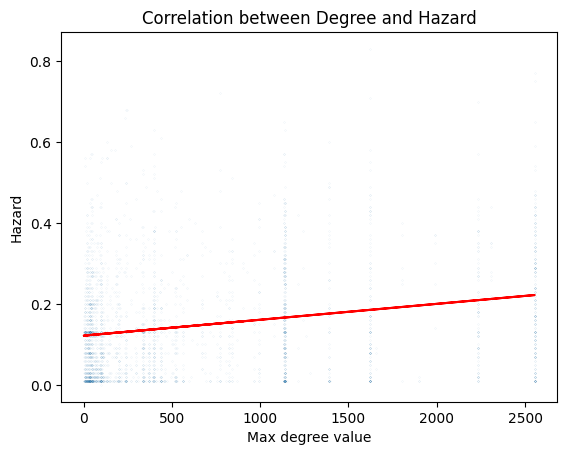

In [47]:
#Then, we will make a correlation plot to visualize whether there is a positive correlation between degree and hazard
import scipy

max_deg_list=[]
haz_list=[]
for chem,max_deg in chem_max_degree.items():
    name_exp=chem_id_name_conversion[chem]
    cas_exp=chem_id_cas_conversion[chem]
    try:
        haz=susdat_toxicity_df[susdat_toxicity_df['Name']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
        if str(haz)!='nan':
            haz_list.append(haz)
            max_deg_list.append(max_deg)
    except:
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['Name_Dashboard']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
            if str(haz)!='nan':
                haz_list.append(haz)
                max_deg_list.append(max_deg)
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['Name_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                if str(haz)!='nan':
                    haz_list.append(haz)
                    max_deg_list.append(max_deg)
            except:
                try:
                    haz=susdat_toxicity_df[susdat_toxicity_df['Name_IUPAC']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                    if str(haz)!='nan':
                        haz_list.append(haz)
                        max_deg_list.append(max_deg)
                except:
                    try:
                        haz=susdat_toxicity_df[susdat_toxicity_df['Synonyms_ChemSpider']==name_exp]['HazScore_EcoChronic_KEMI'].values[0]
                        if str(haz)!='nan':
                            haz_list.append(haz)
                            max_deg_list.append(max_deg)
                    except:
                        try:
                            haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN']=="CAS_RN:"+cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                            if str(haz)!='nan':
                                haz_list.append(haz)
                                max_deg_list.append(max_deg)
                        except:
                            try:
                                haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN_Dashboard']==cas_exp]['HazScore_EcoChronic_KEMI'].values[0]
                                if str(haz)!='nan':
                                    haz_list.append(haz)
                                    max_deg_list.append(max_deg)
                            except: 
                                pass
        
print(len(max_deg_list)==len(haz_list))


print(scipy.stats.pearsonr(max_deg_list,haz_list))  # Pearson's r
print(scipy.stats.spearmanr(max_deg_list,haz_list)) # Spearman's rho
slope, intercept, r, p, stderr = scipy.stats.linregress(max_deg_list,haz_list)
fig, ax = plt.subplots()
ax.scatter(max_deg_list,haz_list, s= 0.001)
y=[]
for i in max_deg_list:
    g=(intercept + slope * i)
    y.append(g)


ax.plot(max_deg_list, y,color='r')
ax.set_xlabel('Max degree value')
ax.set_ylabel('Hazard')

plt.title('Correlation between Degree and Hazard')
#ax.legend(facecolor='white')
plt.show()


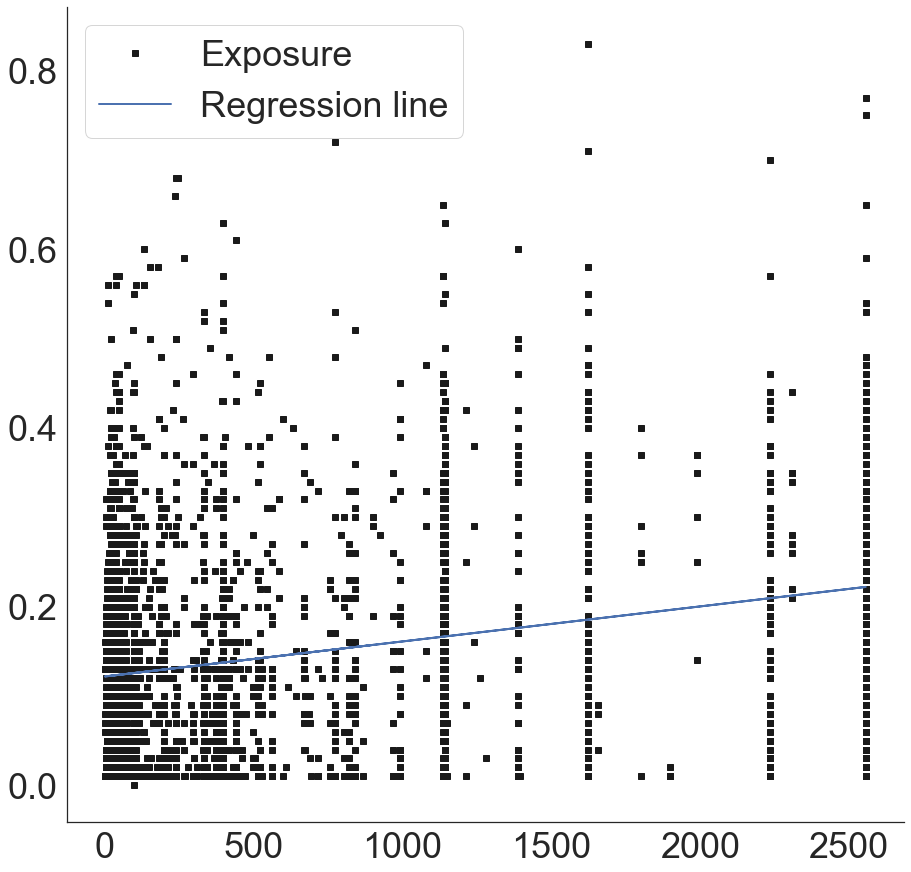

In [53]:

import scipy
from matplotlib.pyplot import figure
from scipy import stats


fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(max_deg_list, haz_list)

ax.plot(max_deg_list,haz_list, linewidth=0, marker='s',c='k', label='Exposure')
y=[]
for i in max_deg_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(max_deg_list, y, label=line,linewidth=2)
#ax.set_xlabel('Max degree value', fontsize=18)
#ax.set_ylabel('Hazard',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
plt.savefig('output/Figures/Figure3Fv2.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [42]:
haz_list=list(deg_haz_dict_sort.keys())
quintile=int(len(haz_list)/5)
haz_list_1=haz_list[:quintile]
haz_list_2=haz_list[quintile:2*quintile]
haz_list_3=haz_list[2*quintile:3*quintile]
haz_list_4=haz_list[3*quintile:4*quintile]
haz_list_5=haz_list[4*quintile:]

In [45]:
len(max_deg_list)

2858

In [60]:
len(deg_haz_df_sort_by_degree)/5

571.6

In [76]:
column_names = ["Hazard", "Degree"]

deg_haz_df = pd.DataFrame(columns = column_names)
deg_haz_df['Hazard']=haz_list
deg_haz_df['Degree']=max_deg_list

In [77]:
deg_haz_df_sort_by_degree=deg_haz_df.sort_values("Degree")

In [55]:
cat_list=[]
for i in range(len(deg_haz_df_sort_by_degree)):
    if i<len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("1st quintile")
    elif i>len(deg_haz_df_sort_by_degree)/5 and i<2*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("2nd quintile")
    elif i>2*len(deg_haz_df_sort_by_degree)/5 and i<3*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("3rd quintile")
    elif i>3*len(deg_haz_df_sort_by_degree)/5 and i<4*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("4th quintile")
    else:
        cat_list.append("5th quintile")
        
deg_haz_df_sort_by_degree["Group"]=cat_list

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_89192/3759707774.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)


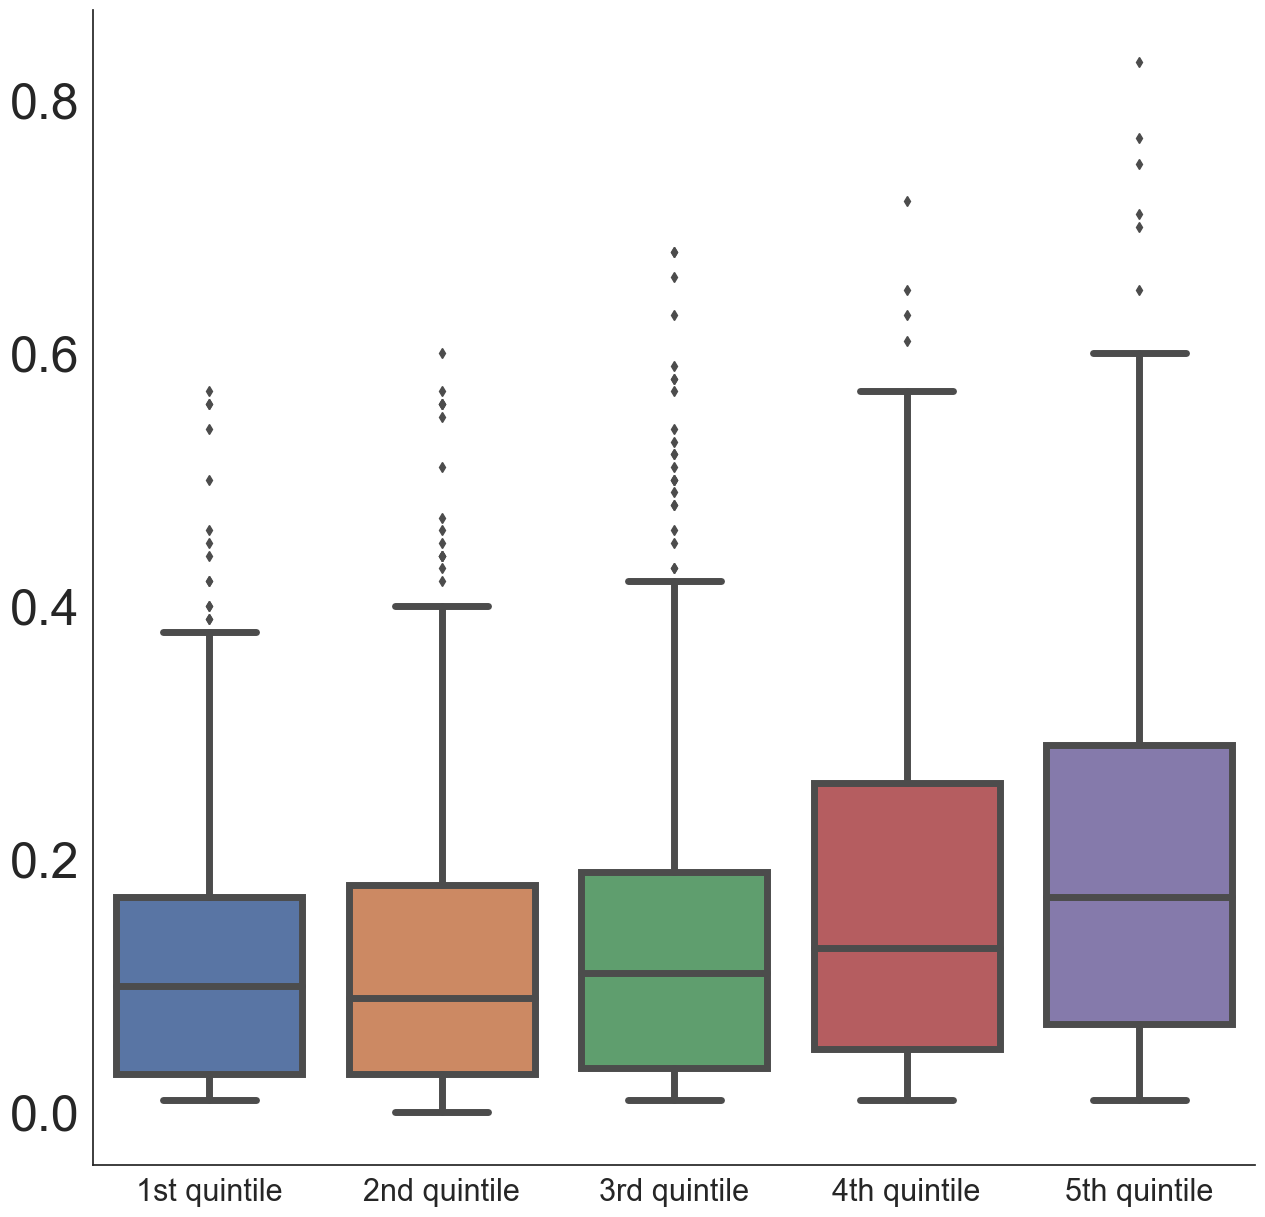

In [59]:
#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))

sns.set_style('white')
sns.set(style="white",font_scale = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=deg_haz_df_sort_by_degree,x="Group", y="Hazard",order=['1st quintile','2nd quintile', '3rd quintile','4th quintile',
 '5th quintile'],linewidth=5)
plt.xlabel('',fontsize=22)
plt.ylabel('', fontsize=22)
#plt.xticks([], fontsize=22)
ax.grid(False)
ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)
#ax.set_xticklabels(ax.get_xticks(), size = 36)
plt.savefig('output/Figures/Figure3Hv2.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#g.set_yscale("log")

plt.show()


In [78]:
cat_list=[]
for i,v in deg_haz_df_sort_by_degree.iterrows():
    if v['Degree']<10:
        cat_list.append("<10")
    elif v['Degree']>10 and v['Degree']<100:
        cat_list.append("<100")
    elif v['Degree']>100 and v['Degree']<1000:
        cat_list.append("<1000")
    else:
        cat_list.append(">1000")
        
deg_haz_df_sort_by_degree["Group"]=cat_list

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_89192/1614140808.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)


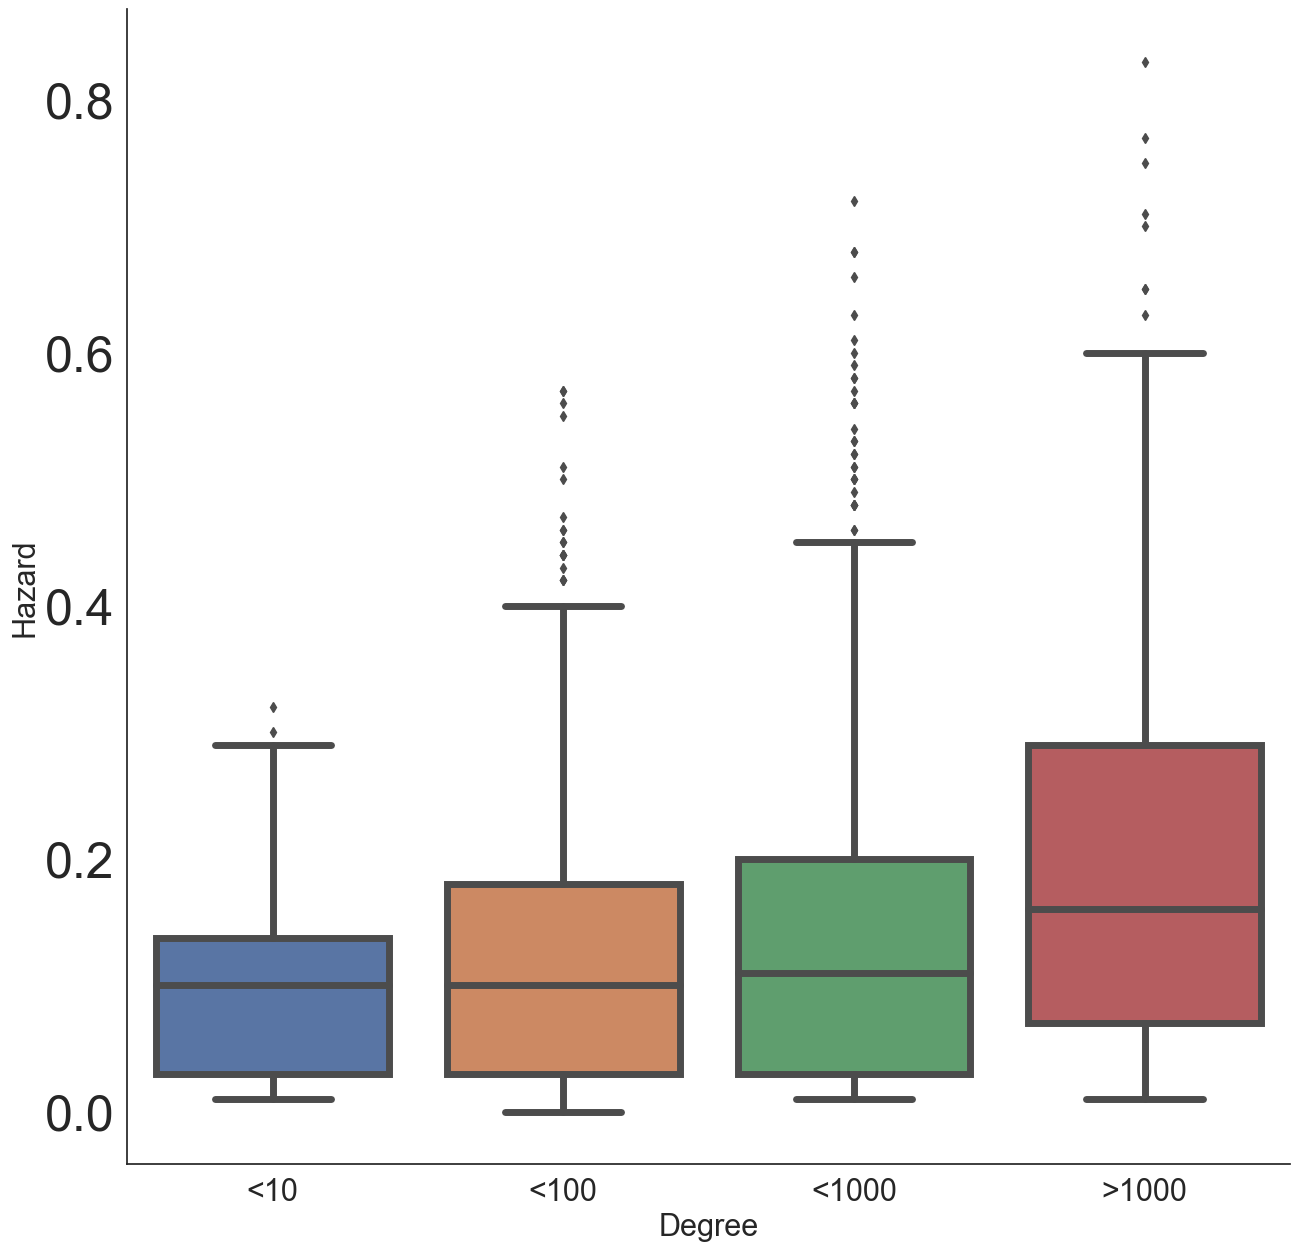

In [81]:
#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))

sns.set_style('white')
sns.set(style="white",font_scale = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=deg_haz_df_sort_by_degree,x="Group", y="Hazard",order=['<10','<100', '<1000','>1000'],linewidth=5)
plt.xlabel('Degree',fontsize=22)
plt.ylabel('Hazard', fontsize=22)
#plt.xticks([], fontsize=22)
ax.grid(False)
ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)
#ax.set_xticklabels(ax.get_xticks(), size = 36)
plt.savefig('output/Figures/Figure3Hv3.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#g.set_yscale("log")

plt.show()

In [79]:
#I can try to interrogate another dataset:OEHHA
#The list contains a wide range of chemicals that are known to cause cancer or birth defects
#https://oehha.ca.gov/proposition-65/proposition-65-list

oehha=pd.read_csv("p65chemicalslist.csv",skiprows=11)

In [80]:
oehha.head()

,Chemical,Type of Toxicity,Listing Mechanism,CAS No.,Date Listed,NSRL or MADL (�g/day)a,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,"A-alpha-C (2-Amino-9H-pyrido[2,3-b]indole)",cancer,AB,26148-68-5,1-Jan-90,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Abiraterone acetate,"developmental, female, male",FR,154229-18-2,8-Apr-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Acetaldehyde,cancer,SQE,75-07-0,1-Apr-88,90 (inhalation),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Acetamide,cancer,AB,60-35-5,1-Jan-90,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Acetazolamide,developmental,FR,59-66-5,20-Aug-99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
#Here we match our exposures IDs with the exposures names and CAS numbers provided by OEHHA
hub_num_dis_list=[]
for exp in hub_exposures_list:
    name_exp=chem_id_name_conversion[exp]
    cas_exp=chem_id_cas_conversion[exp]
    try:
        num_dis=len(oehha[oehha['Chemical']==name_exp]['Type of Toxicity'].values[0].split(','))
        hub_num_dis_list.append(num_dis)
    except:
        try:
            haz=len(oehha[oehha['CAS No.']==cas_exp]['Type of Toxicity'].values[0].split(','))
            hub_num_dis_list.append(haz)
        except:
            pass
cm_num_dis_list=[]
for exp in central_module_exposures_list:
    name_exp=chem_id_name_conversion[exp]
    cas_exp=chem_id_cas_conversion[exp]
    try:
        num_dis=len(oehha[oehha['Chemical']==name_exp]['Type of Toxicity'].values[0].split(','))
        cm_num_dis_list.append(num_dis)
    except:
        try:
            haz=len(oehha[oehha['CAS No.']==cas_exp]['Type of Toxicity'].values[0].split(','))
            cm_num_dis_list.append(haz)
        except:
            pass
        
pm_num_dis_list=[]
for exp in peripheric_module_exposures_list:
    name_exp=chem_id_name_conversion[exp]
    cas_exp=chem_id_cas_conversion[exp]
    try:
        num_dis=len(oehha[oehha['Chemical']==name_exp]['Type of Toxicity'].values[0].split(','))
        pm_num_dis_list.append(num_dis)
    except:
        try:
            haz=len(oehha[oehha['CAS No.']==cas_exp]['Type of Toxicity'].values[0].split(','))
            pm_num_dis_list.append(haz)
        except:
            pass
        
nohubmod_num_dis_list=[]
for exp in no_central_no_module_exposures_list:
    name_exp=chem_id_name_conversion[exp]
    cas_exp=chem_id_cas_conversion[exp]
    try:
        num_dis=len(oehha[oehha['Chemical']==name_exp]['Type of Toxicity'].values[0].split(','))
        nohubmod_num_dis_list.append(num_dis)
    except:
        try:
            haz=len(oehha[oehha['CAS No.']==cas_exp]['Type of Toxicity'].values[0].split(','))
            nohubmod_num_dis_list.append(haz)
        except:
            pass
        
            
print("This is the ratio of found exposures with hazard annotation for hub exposures: %s" %(len(hub_num_dis_list)/len(hub_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for central module exposures: %s" %(len(cm_num_dis_list)/len(central_module_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for peripheric module exposures: %s" %(len(pm_num_dis_list)/len(peripheric_module_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for no module no hub exposures: %s" %(len(nohubmod_num_dis_list)/len(no_central_no_module_exposures_list)))


This is the ratio of found exposures with hazard annotation for hub exposures: 0.0363262508567512
This is the ratio of found exposures with hazard annotation for central module exposures: 0.06068476977567887
This is the ratio of found exposures with hazard annotation for peripheric module exposures: 0.031725888324873094
This is the ratio of found exposures with hazard annotation for no module no hub exposures: 0.025519287833827894


In [87]:
import pandas as pd
column_names = ["Number of pathological processes", "Group"]

num_dis_count_df = pd.DataFrame(columns = column_names)

for i in hub_num_dis_list:
        new_row={"Number of pathological processes":i,"Group":"Hub"}
        num_dis_count_df = num_dis_count_df.append(new_row, ignore_index=True)
        
for i in cm_num_dis_list:
        new_row={"Number of pathological processes":i,"Group":"Central Module"}
        num_dis_count_df = num_dis_count_df.append(new_row, ignore_index=True)
        
for i in pm_num_dis_list:
        new_row={"Number of pathological processes":i,"Group":"Peripheric Module"}
        num_dis_count_df = num_dis_count_df.append(new_row, ignore_index=True)
        
for i in nohubmod_num_dis_list:
        new_row={"Number of pathological processes":i,"Group":"Nomodnohub"}
        num_dis_count_df = num_dis_count_df.append(new_row, ignore_index=True)

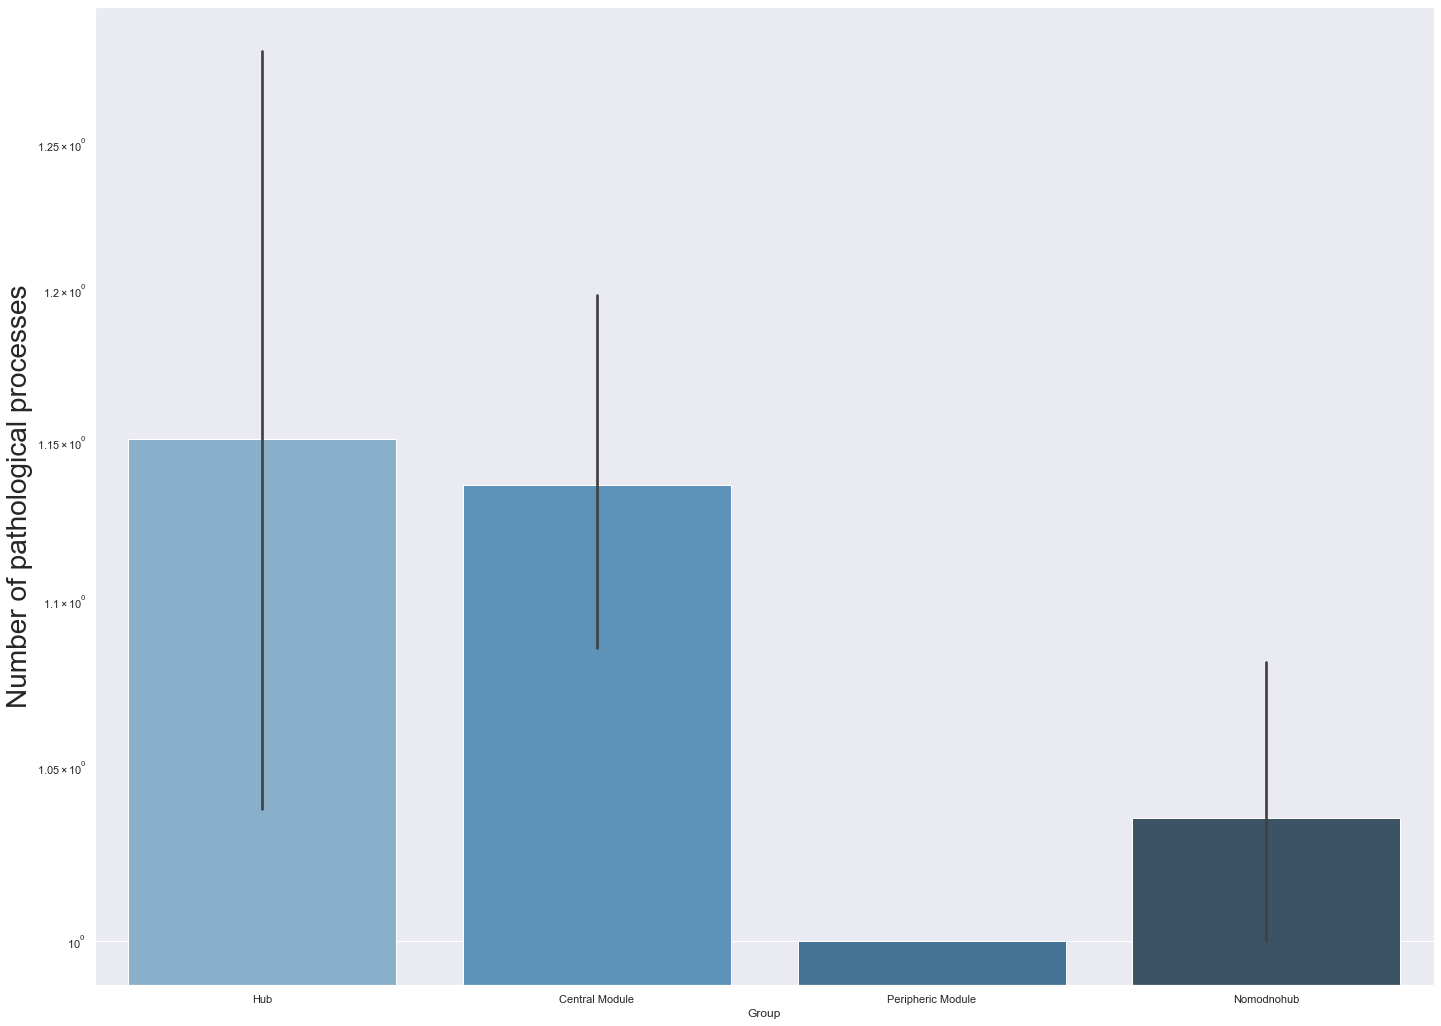

In [90]:
#Let's visualize as barplots
fig, ax = plt.subplots(figsize=(24, 18))
ax = sns.barplot(x="Group", y="Number of pathological processes", data=num_dis_count_df,
                 palette="Blues_d")
ax.set_yscale("log")
#ax.set_title("Association between proximity and literature",fontsize=28)
ax.set_ylabel("Number of pathological processes",fontsize=28)
#ax.set_xlabel("Group",fontsize=28)
plt.show()

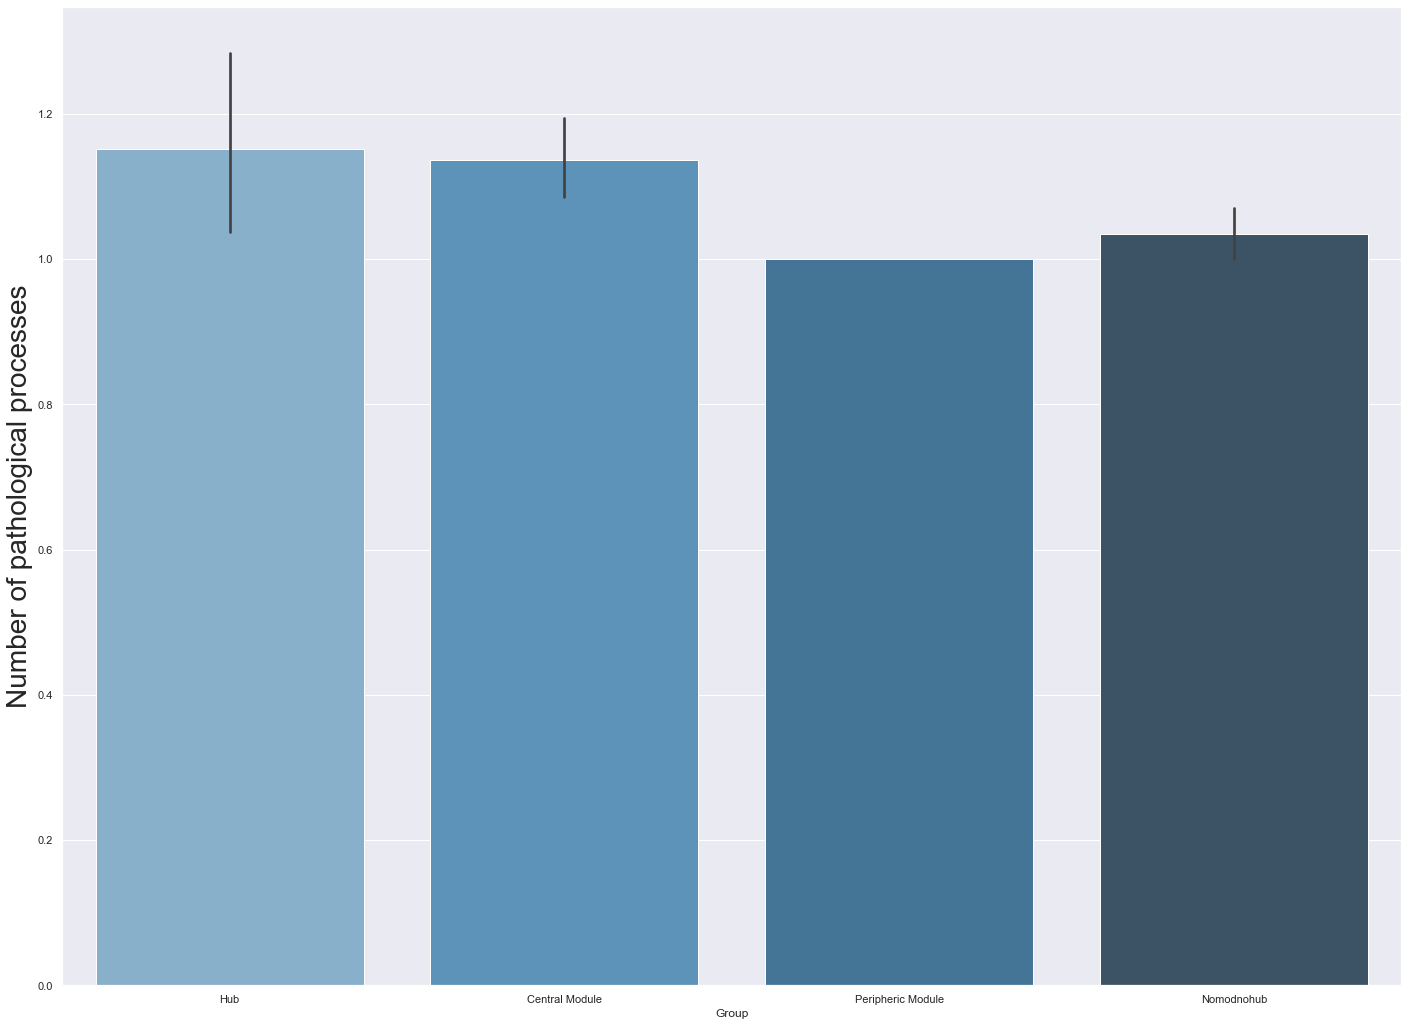

In [93]:
#Let's visualize as barplots
fig, ax = plt.subplots(figsize=(24, 18))
ax = sns.barplot(x="Group", y="Number of pathological processes", data=num_dis_count_df,
                 palette="Blues_d")
#ax.set_yscale("log")
#ax.set_title("Association between proximity and literature",fontsize=28)
ax.set_ylabel("Number of pathological processes",fontsize=28)
#ax.set_xlabel("Group",fontsize=28)
plt.show()

In [91]:
import scipy
print(scipy.stats.mannwhitneyu(hub_num_dis_list, nohubmod_num_dis_list, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(cm_num_dis_list, nohubmod_num_dis_list, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(pm_num_dis_list, nohubmod_num_dis_list, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(cm_num_dis_list, pm_num_dis_list, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(hub_num_dis_list, cm_num_dis_list, use_continuity=True, alternative='two-sided'))




MannwhitneyuResult(statistic=2460.5, pvalue=0.06565507095204381)
MannwhitneyuResult(statistic=11754.0, pvalue=0.06295960181418706)
MannwhitneyuResult(statistic=1037.5, pvalue=0.3524227748229003)
MannwhitneyuResult(statistic=3525.0, pvalue=0.10386649029370693)
MannwhitneyuResult(statistic=6916.0, pvalue=0.734108963236964)
